In [119]:
import qiskit

from qiskit.aqua.algorithms.factorizers import Shor
from qiskit.algorithms import ShorResult
from qiskit.utils import QuantumInstance
import numpy as np
import math
from qiskit import QuantumCircuit, Aer, execute
from qiskit.tools.visualization import plot_histogram

# General background

https://quantum-computing.ibm.com/composer/docs/iqx/guide/shors-algorithm


Task: factor a number N into its prime factors

Step 1:
convert from a factor finding problem to a period finding problem using the Modular Exponentiation Function
https://quantum-computing.ibm.com/composer/docs/iqx/guide/shors-algorithm This takes in the number N and some guess a, divides N with a to get the remainder, and hopes that this function is periodic if u increase the power of a. THis usually happens.

Step 2:
Quantum Fourier transform takes in this periodic function and tries to find its period r. This is qhere the quantum speed-up happens.

Step 3:
Now we have a=guess number; r=period of modular exponentiation function; Now:
P=a^(r/2)-1
Q=a^(r/2)+1
P and Q have co-factors in commmon with N

# First way for any N, works

implementation: https://qiskit.org/documentation/tutorials/algorithms/09_textbook_algorithms.html

function documentation:
    https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.Shor.html

full implementation by IBM: 
    https://www.qiskit.org/documentation/_modules/qiskit/algorithms/factorizers/shor.html

In [ ]:
#N: The integer to be factored, has a min. value of 3.
       #     a: Any integer that satisfies 1 < a < N and gcd(a, N) = 1.
         #   measurement: Boolean flag to indicate if measurement should be included in the circuit.
N = 15
shor = Shor(N)
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024) #shots is the number of repetitions of each circuit, for sampling
result = shor.run(quantum_instance)
print(f"The list of factors of {N} as computed by the Shor's algorithm is {result['factors'][0]}.")

In [ ]:
#Space complexity

#Note: this implementation of Shor’s algorithm uses 4𝑛+2 qubits
#where 𝑛 is the number of bits representing the integer N in binary. 
#So in practice, for now, this implementation is restricted to factorizing small integers. 
#Given the above value of N we compute 4𝑛+2below and confirm the size from the actual circuit.
print('the number {} takes {} bits to be represented in binary'.format(N,math.ceil(math.log(N,2))))
print('the number of qubits Shor uses to factorise it is 4 x {} + 2 = {}'.format(math.ceil(math.log(N, 2)),4 * math.ceil(math.log(N, 2)) + 2))
print(f'Actual number of qubits of circuit: {shor.construct_circuit().num_qubits}')

#What about time complexity
#address shots?
#print probabilities?

#Let's look at how long it takes to factor a number with this many qubits, increase this in steps to see if the predictions are true for
#When it might be possible to break RSA

# Second way for any N, works

from https://www.youtube.com/watch?v=EdJ7RoWcU48

In [198]:
backend=Aer.get_backend('qasm_simulator')
quantum_instance=QuantumInstance(backend, shots=1000)
my_shor=Shor(N=15,a=2,quantum_instance=quantum_instance)
result=Shor.run(my_shor)
result #returns successful_counts which tells the number of experiments tried which gave the right factors

{'factors': [[3, 5]], 'total_counts': 59, 'successful_counts': 18}

# Frist way for N=15 in detail, fails


code: https://www.youtube.com/watch?v=EdJ7RoWcU48

paper: https://arxiv.org/pdf/quant-ph/0205095.pdf

In [126]:
#Modular exponentiation function, hardcoded for N=15
def c_amod15(a, power):
    U=QuantumCircuit(4)
    for iteration in range(power):
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
        for q in range(4):
            U.x(q)
    U=U.to_gate()
    U.name='%i^%i mod 15' %(1,power)
    c_U=U.control()
    return c_U

In [127]:
n_count=8 #number of qubits counting the exponent
a=7 #guess



In [128]:
#Now the quantum fourier transform circuit
def qft_dagger(n):
    qc=QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)),m,j)
        qc.h(j)
    qc.name='QFT dagger'
    return qc
    
    

In [129]:
qc=QuantumCircuit(n_count +4,n_count)
for q in range(n_count):
    qc.h(q)

qc.x(3+n_count)

for q in range(n_count):
    qc.append(c_amod15(1,2**q),[q]+[i+n_count for i in range(4)])
qc.append(qft_dagger(n_count),range(n_count))

qc.measure(range(n_count),range(n_count))
qc.measure(range(n_count),range(n_count))

qc.draw('text')

┌───┐                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────»
      ├───┤       │                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────»
      ├───┤       │              │                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────»
      ├───┤       │              │              │                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────»
      ├───┤       │              │              │              │       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐»
 q_8: ─────┤0            ├┤0            ├┤0            ├┤0            ├»
           │             ││             ││             ││             │»
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├»
           │  1^1 mod 15 ││  1^2 mod 15 ││  1^4 mod 15 ││  1^8 mod 15 │»
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├»
      ┌───┐│             ││             ││             ││             │»
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├»
      └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════»
                                                                       »
«                                                                       »
« q_0: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_1: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_2: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_3: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_4: ───────■─────────────────────────────────────────────────────────»
«             │                                                         »
« q_5: ───────┼───────────────■─────────────────────────────────────────»
«             │               │                                         »
« q_6: ───────┼───────────────┼───────────────■─────────────────────────»
«             │               │               │                         »
« q_7: ───────┼───────────────┼───────────────┼────────────────■────────»
«      ┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐»
« q_8: ┤0             ├┤0             ├┤0             ├┤0              ├»
«      │              ││              ││              ││               │»
« q_9: ┤1             ├┤1             ├┤1             ├┤1              ├»
«      │  1^16 mod 15 ││  1^32 mod 15 ││  1^64 mod 15 ││  1^128 mod 15 │»
«q_10: ┤2             ├┤2             ├┤2             ├┤2              ├»
«      │              ││              ││              ││               │»
«q_11: ┤3             ├┤3             ├┤3             ├┤3              ├»
«      └──────────────┘└──────────────┘└──────────────┘└───────────────┘»
« c: 8/═════════════════════════════════════════════════════════════════»
«                                                                       »
«      ┌─────────────┐┌─┐            

Looking at the circuit above, we first put the counting qubits into the superposition using the Haddamard gates; then we apply the modular exponentiation function to reduce the problem to period finding; and we do quantum fourier transform and measure in the end. this is a hard coded implementation of the general Shors algo for N=15


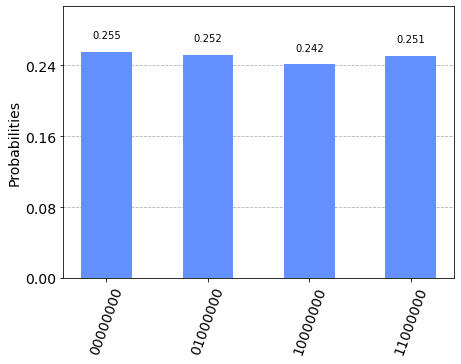

In [136]:
#now we run the circuit above
backend=Aer.get_backend('qasm_simulator')
results=execute(qc,backend, shots=2048).result()
counts=results.get_counts()
plot_histogram(counts)

  Now looking at the above, our algo gave us back four possible values for period r, written in binary. There are 7 binaries, so we interpret the solutions as follows: for a given outcome of the four above, translate this into base 10, divide it with 2^8=256, and once this is simplified your answer is 1/r. This way we get r=1,2,4
  

In [146]:
# convert and add binary periods to list
counts_dec = sorted([int(measured_value[::-1], 2)
                     for measured_value in counts])

print("Measured periods:", end='\t')
periods=[]
for measured_value in counts_dec:
    periods.append(measured_value)
    print(measured_value, end='\t')

Measured periods:	0	1	2	3	

In [147]:

factors = set()

for x in periods:
    guesses = [math.gcd(int((a ** (measured_value/2))) + 1, N),
               math.gcd(int((a ** (measured_value/2))) - 1, N)]
    for guess in guesses:
        # ignore trivial factors
        if guess != 1 and guess != N and N % guess == 0:
            factors.add(guess)

if len(factors):
    P = factors.pop()
    Q = factors.pop() if len(factors) else N // P
    print(f"P = {P}\nQ = {Q}\n\n",
          f"{P} x {Q} = {N}, {P * Q == N}")
else:
    print("Shor's Algorithm Failed. Choose a different 'a'.")

Shor's Algorithm Failed. Choose a different 'a'.


# Second way for N=15 in detail, works

https://medium.com/qiskit/applying-shors-algorithm-bbdfd6f05f7d

In [199]:
from numpy.random import seed, randint
# imports for RSA
from numpy import gcd
from numpy.random import seed, randint
# imports for Shor
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
seed(1)
a = randint(2, N) # 1 < a < N

if math.gcd(a, N) == 1: # a shares no factors
    print(f"{1} < {a} < {N}, {1 < a < N}")
else: # a shares a factor
    P = gcd(a, N)
    Q = N // gcd(a, N)
    print(f"P = {P}\nQ = {Q}\n\n",
          f"{P} x {Q} = {N}, {P * Q == N}\n")

1 < 7 < 15, True


In [200]:
def initialize_qubits(qc, n, m):
    qc.h(range(n)) # apply hadamard gates
    qc.x(n+m-1) # set qubit to 1

In [201]:
print(f"Which in your case is\n\tU(x) = a^x mod {N}")
def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U
def modular_exponentiation(qc, n, m, a):
    for x in range(n):
        exponent = 2**x
        qc.append(a_x_mod15(a, exponent), 
                     [x] + list(range(n, n+m)))

Which in your case is
	U(x) = a^x mod 15


In [202]:
def apply_iqft(qc, measurement_qubits):
    qc.append(QFT(len(measurement_qubits),
                             do_swaps=False).inverse(),
                         measurement_qubits)

In [203]:
def measure(qc, n):
    qc.measure(n, n)

In [204]:
def period_finder(n, m, a):
    
    # set up quantum circuit
    qc = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(qc, n, m)
    qc.barrier()

    # apply modular exponentiation
    modular_exponentiation(qc, n, m, a)
    qc.barrier()

    # apply inverse QFT
    apply_iqft(qc, range(n))
    qc.barrier()

    # measure the n measurement qubits
    measure(qc, range(n))
    
    return qc

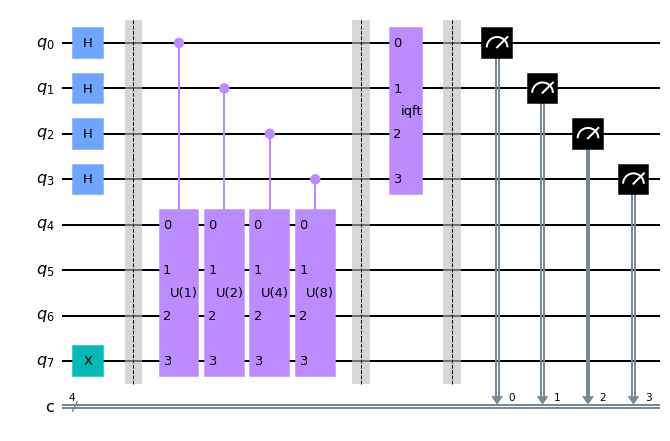

In [205]:
n = 4; m = 4

qc = period_finder(n, m, a)
qc.draw(output='mpl')

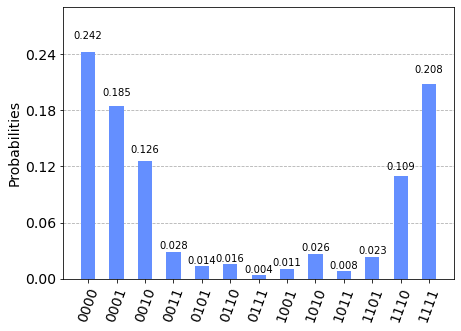

In [206]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator).result().get_counts(qc)

plot_histogram(counts)

In [207]:
# convert and add binary periods to list
counts_dec = sorted([int(measured_value[::-1], 2)
                     for measured_value in counts])

print("Measured periods:", end='\t')
for measured_value in counts_dec:
    print(measured_value, end='\t')

Measured periods:	0	4	5	6	7	8	9	10	11	12	13	14	15	

In [208]:
# convert and add binary periods to list
counts_dec = sorted([int(measured_value[::-1], 2)
                     for measured_value in counts])

print("Measured periods:", end='\t')
for measured_value in counts_dec:
    print(measured_value, end='\t')

Measured periods:	0	4	5	6	7	8	9	10	11	12	13	14	15	

In [209]:
factors = set()

for x in periods:
    guesses = [gcd(int((a ** (measured_value/2))) + 1, N),
               gcd(int((a ** (measured_value/2))) - 1, N)]
    for guess in guesses:
        # ignore trivial factors
        if guess != 1 and guess != N and N % guess == 0:
            factors.add(guess)

if len(factors):
    P = factors.pop()
    Q = factors.pop() if len(factors) else N // P
    print(f"P = {P}\nQ = {Q}\n\n",
          f"{P} x {Q} = {N}, {P * Q == N}")
else:
    print("Shor's Algorithm Failed. Choose a different 'a'.")

P = 3
Q = 5

 3 x 5 = 15, True
